# Inventory Optimization Using Probabilistic Forecasts

This notebook converted probabilistic demand forecasts
into inventory decisions.

Forecast uncertainty was explicitly used to compute
safety stock and reorder points under a service-level
constraint.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)


## Loading Reconciled Forecasts

Reconciled probabilistic forecasts from the previous
notebook were loaded as inputs to inventory optimization.


In [2]:
forecast_df = pd.read_csv("../outputs/forecasts/reconciled_forecasts.csv")

forecast_df["date"] = pd.to_datetime(forecast_df["date"])
forecast_df.head()


,date,sku_store,p10,p50,p90,item_id,store_id,state_id,cat_id,p10_total,p50_total,p90_total,p10_reconciled,p50_reconciled,p90_reconciled
0,2012-02-05,FOODS_3_062_TX_2,0.0,0.0,3.643086,FOODS_3_062,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,3.643086
1,2012-02-05,FOODS_3_123_TX_2,0.0,0.0,0.982428,FOODS_3_123,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,0.982428
2,2012-02-05,HOBBIES_1_409_TX_3,0.0,0.0,1.903983,HOBBIES_1_409,TX_3,TX,HOBBIES,0.0,0.0,326.707637,NaN,NaN,1.903983
3,2012-02-05,HOUSEHOLD_1_021_TX_3,0.0,0.0,3.791410,HOUSEHOLD_1_021,TX_3,TX,HOUSEHOLD,0.0,0.0,326.707637,NaN,NaN,3.791410
4,2012-02-05,FOODS_2_311_TX_3,0.0,0.0,5.011357,FOODS_2_311,TX_3,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,5.011357


## Inventory Optimization Logic

Inventory decisions were derived using classical
safety stock principles.

A target service level was chosen to balance:
- Stockout risk
- Holding cost


In [3]:
# Defined target service level
service_level = 0.95

# Computed z-score corresponding to service level
z_score = norm.ppf(service_level)


## Estimating Demand Mean and Variability

The median forecast represented expected demand,
while the spread between quantiles approximated uncertainty.


In [4]:
# Estimated mean demand using median forecast
forecast_df["mean_demand"] = forecast_df["p50_reconciled"]

# Approximated standard deviation from prediction interval
forecast_df["std_demand"] = (
    forecast_df["p90_reconciled"] - forecast_df["p10_reconciled"]
) / 2


## Computing Safety Stock

Safety stock was computed to protect against demand variability
during the replenishment lead time.


In [5]:
forecast_df["safety_stock"] = z_score * forecast_df["std_demand"]


## Computing Reorder Point

The reorder point was calculated as the sum of
expected demand and safety stock.


In [6]:
forecast_df["reorder_point"] = (
    forecast_df["mean_demand"] + forecast_df["safety_stock"]
)


## Visualizing Inventory Policy

Inventory thresholds were visualized for a sample SKU
to validate behavior under uncertainty.


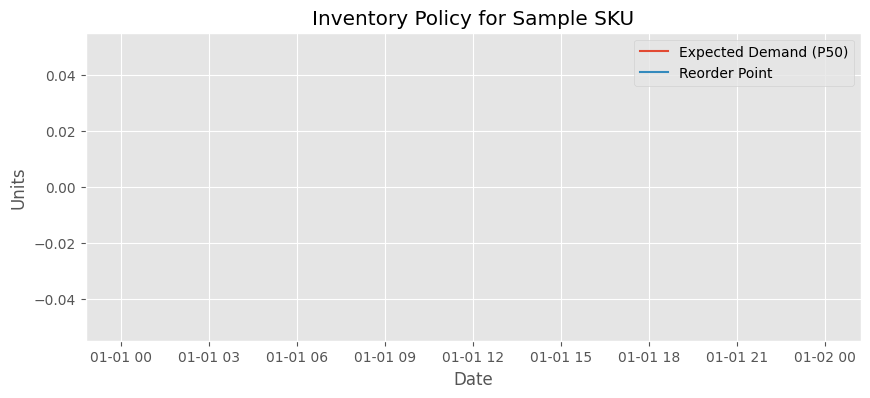

In [7]:
sample_sku = forecast_df["sku_store"].iloc[0]
subset = forecast_df[forecast_df["sku_store"] == sample_sku]

plt.figure(figsize=(10, 4))
plt.plot(subset["date"], subset["mean_demand"], label="Expected Demand (P50)")
plt.plot(subset["date"], subset["reorder_point"], label="Reorder Point")
plt.legend()
plt.title("Inventory Policy for Sample SKU")
plt.xlabel("Date")
plt.ylabel("Units")
plt.show()


## Saving Inventory Decisions

Computed inventory parameters were saved for
monitoring and evaluation.


In [8]:
import os

os.makedirs("../outputs/inventory", exist_ok=True)

forecast_df.to_csv(
    "../outputs/inventory/inventory_policy.csv",
    index=False
)


## Summary

In this notebook:

- Probabilistic forecasts were translated into inventory decisions
- Safety stock was computed using forecast uncertainty
- Reorder points were derived under a service-level constraint
- Inventory policies were visualized and saved

The next notebook monitors forecast performance
and detects concept drift.
